# MNIST数据集

在第一部分，我们从零开始，帮助冰激凌店老板小明创建了一个根据天气预报预测冰激凌销量的多层人工神经元网络模型。在这个过程中，我们深入了解了人工神经元的概念，掌握了神经元网络模型的三条核心数据链路：**前向传播**、**梯度计算**和**反向传播**，并认识到神经元网络的核心逻辑正是基于微积分的**梯度下降**算法。

在第二部分，我们再次从无到有，构建了一个深度学习框架的核心组件：**张量类**、**层类**、**损失函数类**、**优化器类**和**数据集类**，最后用**模型类**将这些模块封装在一起。通过这一工程化的封装，我们实现了**自动微分**机制，让三条数据链路的运行变得自动化且高效。

根据天气预报预测冰激凌销量是一个典型的**数值回归问题**。我们构建的深度学习框架已经能够游刃有余地处理此类任务。

在接下来的第三部分，我们将继续扩展我们的深度学习框架，使其支持**分类问题**。更重要的是，我们将跨入图像处理的领域，探索如何处理**二维特征值**。这将让神经元网络模型拥有“视觉”，使其能够真正“看到”并“看懂”图像。

In [6]:
import matplotlib.pyplot as plt
from abc import abstractmethod, ABC

import numpy as np

np.random.seed(99)

## 基础架构

### 张量

为了让张量可以处理多维度数据（比如图像是二维数据）批次，我们再次修改Size()函数，返回数据各维度的特征值数量总和（比如对于3\*3的图像数据，返回9）。同时我们引入一个新的shape()函数，返回数据各维度的形状（比如对于批大小为2的3\*3图像数据，返回(2,3,3)）。

In [7]:
class Tensor:

    def __init__(self, data):
        self.data = np.array(data)
        self.grad = np.zeros_like(self.data)
        self.gradient_fn = lambda: None
        self.parents = set()

    def backward(self):
        if self.gradient_fn:
            self.gradient_fn()

        for p in self.parents:
            p.backward()

    def size(self):
        return np.prod(self.data.shape[1:])

    def __str__(self):
        return f'Tensor({self.data})'

### 基础数据集

In [8]:
class Dataset(ABC):

    def __init__(self, batch_size=1):
        self.batch_size = batch_size
        self.load()
        self.train()

    @abstractmethod
    def load(self):
        pass

    def train(self):
        self.features = self.train_features
        self.labels = self.train_labels

    def eval(self):
        self.features = self.test_features
        self.labels = self.test_labels

    def shape(self):
        return Tensor(self.features).size(), Tensor(self.labels).size()

    def items(self):
        return Tensor(self.features), Tensor(self.labels)

    def __len__(self):
        return len(self.features) // self.batch_size

    def __getitem__(self, index):
        start = index * self.batch_size
        end = start + self.batch_size

        feature = Tensor(self.features[start: end])
        label = Tensor(self.labels[start: end])
        return feature, label

## 数据

### MINST数据集

MNIST数据集是”视觉“机器学习界的”Hello World!“。它包含了70,000张手写数字的灰度图片（分为训练数据和测试数据）。虽然对人类来说，分辨从0到9轻而易举，但对计算机而言，这只是784个从0到255变化的像素点阵。

在这一部分，我们的目标是：扩展我们的深度学习框架，从而能够构建一个神经元网络模型，从这些看似杂乱的像素中，提取出‘笔画’和‘形状’信息，并最终告诉我们：这写的是几？”

### 数据预处理

在加载完MNIST原始数据后，我们通常不能直接将其输入神经网络。而是需要进行一系列数据预处理操作，以提升模型训练的稳定性、收敛速度与最终性能。主要包括以下三个关键步骤：

1. **归一化**（Normalization）：MNIST图像的像素值为0–255的整数。若直接作为网络输入，较大的数值范围可能导致**梯度爆炸**（Exploding Gradient）、或者**梯度消失**（Vanishing Gradient）。为此，我们通常将像素值除以255，将其线性缩放到[0, 1]区间。这不仅统一了输入尺度，也更符合多数激活函数与优化器对输入分布的隐含假设。

2. **维度扩展**（Dimension Expansion）：MNIST图像数据结构是三维(N,28,28)。其中N为样本数量，后两维表示图像的高度与宽度。MNIST图像是灰度图（单通道），因此没有代表颜色的维度（通道）。我们需要给它增加一个维度，转换为四维(N,1,28,28)，和其他彩色图像保持一致。

3. 标签**独热编码**（One-Hot Encoding）：MNIST标签为0–9的整数。这些数字不代表大小，只代表类别。若直接以整型作为标签，可能使模型误以为是数值回归问题，而不是分类问题。通过独热编码，我们将每个标签转换为一个长度为10的向量：例如标签2会被编码为 [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]。通过这种方式，让模型明白，需要学习的是标签的位置，而不是大小。

In [9]:
class MINSTDataset(Dataset):

    def __init__(self, filename, batch_size=1):
        self.filename = filename
        super().__init__(batch_size)

    def load(self):
        with (np.load(self.filename, allow_pickle=True) as f):
            self.train_features, self.train_labels = self.normalize(f['x_train'], f['y_train'])
            self.test_features, self.test_labels = self.normalize(f['x_test'], f['y_test'])

    @staticmethod
    def normalize(x, y):
        # 归一化
        inputs = x / 255
        # 维度扩展
        inputs = np.expand_dims(inputs, axis=1)
        # 独热编码
        targets = np.zeros((len(y), 10))
        targets[range(len(y)), y] = 1
        return inputs, targets

## 验证

### 测试

为了加快模型训练速度，我们从MNIST数据集中随机选择了2000个训练数据、和1000个测试数据，组成了TinyMINST数据集。

In [10]:
dataset = MINSTDataset('tinymnist.npz')

print(f'train data count: {len(dataset.train_features)}')
print(f'test data count: {len(dataset.test_features)}')

feature, label = dataset[0]

print(f'feature shape: {feature.data.shape}')
print(f'label shape: {label.data.shape}')

train data count: 2000
test data count: 1000
feature shape: (1, 1, 28, 28)
label shape: (1, 10)


### 图例

最后，让我们看一下MNIST图像看起来是什么样子。

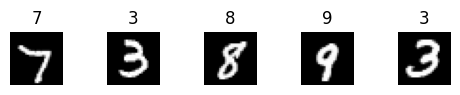

In [11]:
fig, axes = plt.subplots(1, 5, figsize=(5, 1))

for i in range(5):
    feature, label = dataset[i]
    image = feature.data.squeeze()
    label = np.argmax(label.data)

    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(label)
    axes[i].axis('off')

plt.tight_layout()
plt.show()